In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="2"

import argparse
import torch
import torchvision
import torch.nn.functional as F
import numpy as np

from nn.enums import ExplainingMethod
from nn.networks import ExplainableNet
from nn.utils import get_expl, plot_overview, clamp, load_image, make_dir
import keras
from keras import datasets 
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import model_from_json, load_model

no display found. Using non-interactive Agg backend


Using TensorFlow backend.
/home/raj_vardhan/anaconda3/envs/torch_env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/raj_vardhan/anaconda3/envs/torch_env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/raj_vardhan/anaconda3/envs/torch_env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1

In [2]:
def get_beta(i, num_iter):
    """
    Helper method for beta growth
    """
    start_beta, end_beta = 10.0, 100.0
    return start_beta * (end_beta / start_beta) ** (i / num_iter)

# def np_img_to_tensor(grayscale_img):
#     rgb_img = np.repeat(grayscale_img[..., np.newaxis], 3, -1)
#     im = Image.fromarray(rgb_img)
#     x = torchvision.transforms.Normalize(mean=data_mean, std=data_std)(torchvision.transforms.ToTensor()(torchvision.transforms.Resize(224)(im)))
#     x = x.unsqueeze(0).to(device)
#     return x

def np_img_to_tensor(input_img,data_mean,data_std, device, num_ch=1):
    if num_ch == 1:
        rgb_img = np.repeat(input_img[..., np.newaxis], 3, -1)
    else:
        rgb_img = input_img
    im = Image.fromarray(rgb_img)
    x = torchvision.transforms.Normalize(mean=data_mean, std=data_std)(torchvision.transforms.ToTensor()(torchvision.transforms.Resize(224)(im)))
    x = x.unsqueeze(0).to(device)
    return x

In [3]:
# args
args_cuda = True
args_method = 'guided_backprop'
args_beta_growth = None
args_num_iter = 500
args_prefactors = [1e11, 1e6]
args_lr = 2* (10**(-3))
args_output_dir = '../output/'
args_role = 'adversary'
args_dataset = 'cifar10'
target_class_idx = 6
attack_method = 'cwl2/conf_0'
args_adv_dir = '../../xai-adv/data/postndss/{}/{}/target_next/target_{}/{}/'
if args_dataset == 'fmnist':
    num_ch = 1
    side = 28
elif args_dataset == 'cifar10':
    num_ch = 3
    side = 32

In [4]:
# options
device = torch.device("cuda" if args_cuda else "cpu")
method = getattr(ExplainingMethod, args_method)
print('Explanation method {} will be used'.format(method))

# load model
data_mean = np.array([0.0, 0.0, 0.0])
data_std = np.array([1.0, 1.0, 1.0])

vgg_model = torchvision.models.vgg16(pretrained=True)
model = ExplainableNet(vgg_model, data_mean=data_mean, data_std=data_std, beta=1000 if args_beta_growth else None)
if method == ExplainingMethod.pattern_attribution:
    model.load_state_dict(torch.load('../models/model_vgg16_pattern_small.pth'), strict=False)
model = model.eval().to(device)

print(vgg_model)

Explanation method ExplainingMethod.guided_backprop will be used
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
 

In [5]:
adv_dir = args_adv_dir.format(args_role, args_dataset, str(target_class_idx), attack_method)
x_train = np.load(adv_dir + '/x_adv_ar.npy')
print('Loading {} adv samples from {} '.format(x_train.shape[0],adv_dir))
x_train = x_train[0:10]
print('Retaining {} adv samples'.format(x_train.shape[0]))
x_train = (x_train*255).astype(np.uint8)

Loading 100 adv samples from ../../xai-adv/data/postndss/adversary/cifar10/target_next/target_6/cwl2/conf_0/ 
Retaining 10 adv samples


In [6]:
# The sample is initialized with adversarial example. We will derive adv2 from this 
sample = x_train[0]
print(sample.shape)
print(np.min(sample), np.max(sample))

(32, 32, 3)
2 219


In [7]:
x = np_img_to_tensor(sample, data_mean, data_std, device, num_ch=3)
x_adv = x.clone().detach().requires_grad_()
print(x.shape)
print(torch.min(x), torch.max(x),torch.mean(x))

torch.Size([1, 3, 224, 224])
tensor(0.0078, device='cuda:0') tensor(0.8588, device='cuda:0') tensor(0.3652, device='cuda:0')


In [8]:
x_pred = model(x)
x_pred_class = torch.argmax(x_pred,axis=1)
print('original class of x is ',int(x_pred_class))

original class of x is  274


This is the adversarial example


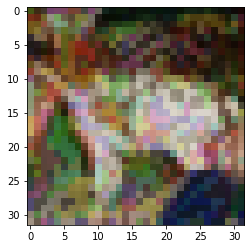

In [9]:
print('This is the adversarial example')
plt.imshow(sample)

In [10]:
org_expl, org_acc, org_idx = get_expl(model, x, method)
org_expl = org_expl.detach().cpu()

This is the current explanation of the adversarial example


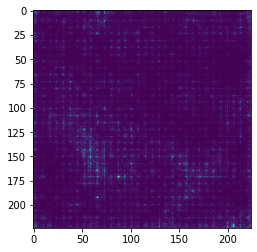

In [11]:
print('This is the current explanation of the adversarial example')
org_expl_np = org_expl.cpu().numpy()
plt.imshow(org_expl_np[0])

In [12]:
if args_dataset == 'fmnist':
    (x_train_orig, y_train_orig), (x_test_orig, y_test_orig) = datasets.fashion_mnist.load_data()
elif args_dataset == 'cifar10':
    (x_train_orig, y_train_orig), (x_test_orig, y_test_orig) = datasets.cifar10.load_data()

In [13]:
# The class from which we will derive the target explanation
for target_class_idx in range(10):
# pick index of x_train where the label is that of the source class
    print('\n-----target_class_idx:{}-----'.format(target_class_idx))
    for choice in range(40):
        print('choice: ',choice)
        idx = np.where(y_train_orig == target_class_idx)[0][choice]
        img_src = x_train_orig[idx]
        x_target = np_img_to_tensor(img_src, data_mean, data_std, device, num_ch)
        target_expl, _, _ = get_expl(model, x_target, method)
        target_expl = target_expl.detach()

        #print('This is an image from the target class which we will use to produce the target explanation')
        #plt.imshow(x_train_orig[idx])

        #print('This is the target explanation we want')
        target_expl_np = target_expl.cpu().numpy()
        #plt.imshow(target_expl_np[0])

        print(target_expl_np.shape)
        target_expl_np = target_expl_np.reshape(224, 224)
        im2 = Image.fromarray(target_expl_np)
        target_expl_np2 = torchvision.transforms.ToTensor()(torchvision.transforms.Resize(side)(im2))
        target_expl_np2 = target_expl_np2.numpy()
        target_expl_np2 = target_expl_np2.reshape(side, side)
        print(target_expl_np2.shape)
        #plt.imshow(target_expl_np2)


        orig_dir = '../data/defender/'+ args_dataset+'/orig/train/' + args_method + '/' + str(target_class_idx)
        model_dir = orig_dir + '/model'

        # Load pre-trained model
        exp_model = load_model(model_dir + '/exp_model.h5')



        #print(np.min(target_expl_np2), np.max(target_expl_np2))

        t_exp = target_expl_np2
        t_exp *= 255.0/np.max(t_exp)
        t_exp = t_exp.astype(int)

        #print(np.min(t_exp), np.max(t_exp))

        t_exp = t_exp.reshape(-1,side,side,1)

        #evaluate model on adv samples
        result_test = exp_model.predict(t_exp)
        #print(result_test)
        result_test_class = np.argmax(result_test, axis=1)[0]
        print(result_test_class)
        if result_test_class == 0:
            print('choose {} for target class idx {}'.format(choice,target_class_idx))
            break
    


-----target_class_idx:0-----
choice:  0
(1, 224, 224)
(32, 32)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
1
choice:  1
(1, 224, 224)
(32, 32)
1
choice:  2
(1, 224, 224)
(32, 32)
0
choose 2 for target class idx 0

-----target_class_idx:1-----
choice:  0
(1, 224, 224)
(32, 32)
0
choose 0 for target class idx 1

-----target_class_idx:2-----
choice:  0
(1, 224, 224)
(32, 32)
1
choice:  1
(1, 224, 224)
(32, 32)
0
choose 1 for target class idx 2

-----target_class_idx:3-----
choice:  0
(1, 224, 224)
(32, 32)
0
choose 0 for target class idx 3

-----target_class_idx:4-----
choice:  0
(1, 224, 224)
(32, 32)
0
choose 0 for target class idx 4

-----target_class_idx:5-----
choice:  0
(1, 224, 224)
(32, 32)
0
choose 0 for target class idx 5

-----target_class_idx:6-----
choice:  0
(1, 224, 224)
(32, 32)
1
choice:  1
(1, 224, 224)
(32, 32)
0
choose 1 for target class idx 6

-----target_class_idx:7-----
choice:  0
(1, 224, 

### Now we do the attack and produce adv2 which results in the target explanation map

In [27]:
optimizer = torch.optim.Adam([x_adv], lr=args_lr)

for i in range(args_num_iter):
    if args_beta_growth:
        model.change_beta(get_beta(i, args_num_iter))

    optimizer.zero_grad()

    # calculate loss
    adv_expl, adv_acc, class_idx = get_expl(model, x_adv, method, desired_index=org_idx)
    loss_expl = F.mse_loss(adv_expl, target_expl)
    loss_output = F.mse_loss(adv_acc, org_acc.detach())
    total_loss = args_prefactors[0]*loss_expl + args_prefactors[1]*loss_output

    # update adversarial example
    total_loss.backward()
    optimizer.step()

    # clamp adversarial example
    # Note: x_adv.data returns tensor which shares data with x_adv but requires
    #       no gradient. Since we do not want to differentiate the clamping,
    #       this is what we need
    x_adv.data = clamp(x_adv.data, data_mean, data_std)

    print("Iteration {}: Total Loss: {}, Expl Loss: {}, Output Loss: {}".format(i, total_loss.item(), loss_expl.item(), loss_output.item()))

Iteration 0: Total Loss: 29.564104080200195, Expl Loss: 2.956410394272524e-10, Output Loss: 0.0
Iteration 1: Total Loss: 24.197696685791016, Expl Loss: 2.2469076599307414e-10, Output Loss: 1.7286214415435097e-06
Iteration 2: Total Loss: 37.609886169433594, Expl Loss: 1.957259354590235e-10, Output Loss: 1.803729173843749e-05
Iteration 3: Total Loss: 19.39965057373047, Expl Loss: 1.780490338498808e-10, Output Loss: 1.5947479141686927e-06
Iteration 4: Total Loss: 20.184892654418945, Expl Loss: 1.653770315135361e-10, Output Loss: 3.647189487310243e-06
Iteration 5: Total Loss: 18.65789794921875, Expl Loss: 1.5592109547934996e-10, Output Loss: 3.065788177991635e-06
Iteration 6: Total Loss: 16.500844955444336, Expl Loss: 1.5100991290761812e-10, Output Loss: 1.3998541135151754e-06
Iteration 7: Total Loss: 15.269168853759766, Expl Loss: 1.4606579834541833e-10, Output Loss: 6.62589457078866e-07
Iteration 8: Total Loss: 14.62734317779541, Expl Loss: 1.3782278096563516e-10, Output Loss: 8.45064732

Iteration 72: Total Loss: 1.7446519136428833, Expl Loss: 1.6217280990327154e-11, Output Loss: 1.229238648647879e-07
Iteration 73: Total Loss: 1.792284607887268, Expl Loss: 1.6049711906718223e-11, Output Loss: 1.8731347495304362e-07
Iteration 74: Total Loss: 1.643205165863037, Expl Loss: 1.580685929369885e-11, Output Loss: 6.251929818290591e-08
Iteration 75: Total Loss: 1.687652349472046, Expl Loss: 1.560497217556467e-11, Output Loss: 1.2715520369965816e-07
Iteration 76: Total Loss: 1.6396260261535645, Expl Loss: 1.5365516151111258e-11, Output Loss: 1.0307442721568805e-07
Iteration 77: Total Loss: 1.5786190032958984, Expl Loss: 1.5157425661826984e-11, Output Loss: 6.287641696189894e-08
Iteration 78: Total Loss: 1.609121561050415, Expl Loss: 1.4983715657113095e-11, Output Loss: 1.1075006511873653e-07
Iteration 79: Total Loss: 1.5452468395233154, Expl Loss: 1.4798393413451016e-11, Output Loss: 6.5407540716933e-08
Iteration 80: Total Loss: 1.5392260551452637, Expl Loss: 1.4591777439121323e

Iteration 144: Total Loss: 0.8572586178779602, Expl Loss: 8.195302943214688e-12, Output Loss: 3.7728380419821406e-08
Iteration 145: Total Loss: 0.8527095317840576, Expl Loss: 8.12856379428517e-12, Output Loss: 3.9853169653270015e-08
Iteration 146: Total Loss: 0.8438606262207031, Expl Loss: 8.076793574229857e-12, Output Loss: 3.6181265983259436e-08
Iteration 147: Total Loss: 0.8410282731056213, Expl Loss: 8.02986670211947e-12, Output Loss: 3.804157344688974e-08
Iteration 148: Total Loss: 0.8312413096427917, Expl Loss: 7.954127807796585e-12, Output Loss: 3.582853125294605e-08
Iteration 149: Total Loss: 0.8249569535255432, Expl Loss: 7.884639989519382e-12, Output Loss: 3.649296687058268e-08
Iteration 150: Total Loss: 0.8172633051872253, Expl Loss: 7.818288551286745e-12, Output Loss: 3.543448201526189e-08
Iteration 151: Total Loss: 0.8103989362716675, Expl Loss: 7.77428468823338e-12, Output Loss: 3.2970497443329805e-08
Iteration 152: Total Loss: 0.8016872406005859, Expl Loss: 7.66602580026

Iteration 216: Total Loss: 0.5509031414985657, Expl Loss: 5.28557796489193e-12, Output Loss: 2.2345362893361198e-08
Iteration 217: Total Loss: 0.5478892922401428, Expl Loss: 5.2552372176162265e-12, Output Loss: 2.2365549412484143e-08
Iteration 218: Total Loss: 0.5465530157089233, Expl Loss: 5.232713568004144e-12, Output Loss: 2.3281701899691143e-08
Iteration 219: Total Loss: 0.5419033169746399, Expl Loss: 5.203725037677964e-12, Output Loss: 2.1530814464654213e-08
Iteration 220: Total Loss: 0.5398134589195251, Expl Loss: 5.1822374516619085e-12, Output Loss: 2.1589723786519244e-08
Iteration 221: Total Loss: 0.536618709564209, Expl Loss: 5.155674498436014e-12, Output Loss: 2.105130292306967e-08
Iteration 222: Total Loss: 0.5339191555976868, Expl Loss: 5.125202779537874e-12, Output Loss: 2.1398886218548796e-08
Iteration 223: Total Loss: 0.5306057333946228, Expl Loss: 5.094915808689926e-12, Output Loss: 2.1114148651690812e-08
Iteration 224: Total Loss: 0.5278897285461426, Expl Loss: 5.06422

Iteration 288: Total Loss: 0.41730478405952454, Expl Loss: 3.938333166531027e-12, Output Loss: 2.347147542991479e-08
Iteration 289: Total Loss: 0.40982913970947266, Expl Loss: 3.909782220201663e-12, Output Loss: 1.8850913718893025e-08
Iteration 290: Total Loss: 0.40941810607910156, Expl Loss: 3.899041246119284e-12, Output Loss: 1.9513988647190672e-08
Iteration 291: Total Loss: 0.40909361839294434, Expl Loss: 3.885748927484611e-12, Output Loss: 2.051870495733965e-08
Iteration 292: Total Loss: 0.4043835699558258, Expl Loss: 3.8673400419575454e-12, Output Loss: 1.764955470662244e-08
Iteration 293: Total Loss: 0.4044743478298187, Expl Loss: 3.853995247937725e-12, Output Loss: 1.9074830603926785e-08
Iteration 294: Total Loss: 0.40352851152420044, Expl Loss: 3.845315559025675e-12, Output Loss: 1.8996969330942193e-08
Iteration 295: Total Loss: 0.4015997350215912, Expl Loss: 3.830870950322085e-12, Output Loss: 1.8512640309609196e-08
Iteration 296: Total Loss: 0.4008410573005676, Expl Loss: 3.8

Iteration 360: Total Loss: 0.36406493186950684, Expl Loss: 3.442313274704123e-12, Output Loss: 1.983360853330396e-08
Iteration 361: Total Loss: 0.36138150095939636, Expl Loss: 3.4298061352827647e-12, Output Loss: 1.8400902135340402e-08
Iteration 362: Total Loss: 0.35703837871551514, Expl Loss: 3.3947935608458213e-12, Output Loss: 1.755901202216137e-08
Iteration 363: Total Loss: 0.35798636078834534, Expl Loss: 3.3949013305417663e-12, Output Loss: 1.849625519412257e-08
Iteration 364: Total Loss: 0.3555419445037842, Expl Loss: 3.365906728683421e-12, Output Loss: 1.8951260116750746e-08
Iteration 365: Total Loss: 0.35027921199798584, Expl Loss: 3.326371730144606e-12, Output Loss: 1.764205492804649e-08
Iteration 366: Total Loss: 0.35001593828201294, Expl Loss: 3.326294534949925e-12, Output Loss: 1.738650823313037e-08
Iteration 367: Total Loss: 0.3492316007614136, Expl Loss: 3.3162832289296285e-12, Output Loss: 1.760326284738767e-08
Iteration 368: Total Loss: 0.34719374775886536, Expl Loss: 3

Iteration 430: Total Loss: 0.28662383556365967, Expl Loss: 2.679319873605257e-12, Output Loss: 1.8691862280206806e-08
Iteration 431: Total Loss: 0.28322604298591614, Expl Loss: 2.6668270456525756e-12, Output Loss: 1.654337111745008e-08
Iteration 432: Total Loss: 0.28030771017074585, Expl Loss: 2.663915095457714e-12, Output Loss: 1.3916201524466487e-08
Iteration 433: Total Loss: 0.2793324589729309, Expl Loss: 2.656735942352384e-12, Output Loss: 1.3658878472710967e-08
Iteration 434: Total Loss: 0.28090423345565796, Expl Loss: 2.650497226211468e-12, Output Loss: 1.5854512369628537e-08
Iteration 435: Total Loss: 0.28183403611183167, Expl Loss: 2.643712939537357e-12, Output Loss: 1.7462765455888984e-08
Iteration 436: Total Loss: 0.27995383739471436, Expl Loss: 2.633879008992479e-12, Output Loss: 1.6565959271019892e-08
Iteration 437: Total Loss: 0.2763746678829193, Expl Loss: 2.621725319479351e-12, Output Loss: 1.4202139908547906e-08
Iteration 438: Total Loss: 0.27508553862571716, Expl Loss:

In [28]:
# Test with original model (with relu activations)
model.change_beta(None)

# find the predicted class of x_adv2
x_adv_pred = model(x_adv)
print('predicted class of x_adv_2 is ',torch.argmax(x_adv_pred,axis=1))

adv_expl, _, _ = get_expl(model, x_adv, method)

# save results
# output_dir = make_dir(args_output_dir)
# plot_overview([x_target, x, x_adv], [target_expl, org_expl, adv_expl], data_mean, data_std, filename=f"{output_dir}overview_{args_method}.png")
# torch.save(x_adv, f"{output_dir}x_{args_method}.pth")

predicted class of x_adv_2 is  tensor([274], device='cuda:0')


In [29]:
print(type(x_adv))
print(torch.min(x_adv), torch.max(x_adv))
print(torch.mean(x_adv))

<class 'torch.Tensor'>
tensor(0., device='cuda:0', grad_fn=<MinBackward1>) tensor(0.9144, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.3655, device='cuda:0', grad_fn=<MeanBackward0>)


In [30]:
x_advs = torch.empty(10, 1, 3, 224, 224)
for i in range(10):
    x_advs[i] = x_adv
torch.save(x_advs, "../data/x_advs.pt")
x_adv_loaded = torch.load("../data/x_advs.pt")
loaded_sample = x_adv_loaded[0].to(device)
x_adv_new = loaded_sample.clone().detach().requires_grad_()
adv_expl, _, _ = get_expl(model,x_adv_new, method)

torch.Size([1, 224, 224])
(32, 32)


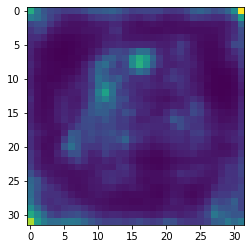

In [34]:
print(adv_expl.shape)
adv_expl = adv_expl.detach().cpu()
adv_expl_np = adv_expl.numpy()
adv_expl_np = adv_expl_np.reshape(224, 224)
im2 = Image.fromarray(adv_expl_np)
adv_expl2 = torchvision.transforms.ToTensor()(torchvision.transforms.Resize(side)(im2))
adv_expl_np2 = adv_expl2.numpy()
adv_expl_np2 = adv_expl_np2.reshape(side, side)
print(adv_expl_np2.shape)
plt.imshow(adv_expl_np2)

# Retrieve the resulting adversarial example

In [58]:
distortion = np.mean([float(torch.sum((x_adv[0][0]-x[0][0])**2)**.5), 
                      float(torch.sum((x_adv[0][1]-x[0][1])**2)**.5), 
                      float(torch.sum((x_adv[0][2]-x[0][2])**2)**.5)])

In [59]:
distortion

4.568252722422282

In [18]:
side = 28

In [44]:
x_adv2_big = x_adv.detach().cpu().numpy()
print(x_adv2_big.shape)
im2 = Image.fromarray(x_adv2_big[0][0])
x_adv2_small = torchvision.transforms.ToTensor()(torchvision.transforms.Resize(side)(im2))
x_adv2_small_np = x_adv2_small.numpy()
#x_adv2_small_np = x_adv2_small_np.reshape(side, side)
#x_adv2_small_np = (x_adv2_small_np *255).astype(np.uint8)

TypeError: Cannot handle this data type

In [36]:
x_adv2_small_np.shape

(1, 32, 32)

In [41]:
print(np.min(x_adv2_big), np.max(x_adv2_big))

0.0 1.0


In [40]:
print(np.min(x_adv2_small_np), np.max(x_adv2_small_np))

0.0044801235 0.80561244


In [36]:
print(np.min(x_adv2_small_np), np.max(x_adv2_small_np))

1 205


This is the adv_2 adversarial example which produces the target map by the target explanation method


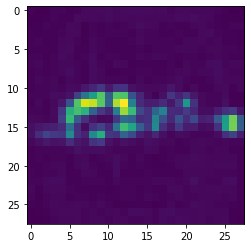

In [23]:
print('This is the adv_2 adversarial example which produces the target map by the target explanation method')
plt.imshow(x_adv2_small_np)

0 254
1 205


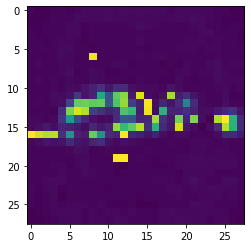

In [26]:
print(np.min(sample), np.max(sample))
print(np.min(x_adv2_small_np), np.max(x_adv2_small_np))

# changes between adv and adv2
pert = abs(x_adv2_small_np - sample)
plt.imshow(pert)

torch.Size([1, 224, 224])
(28, 28)


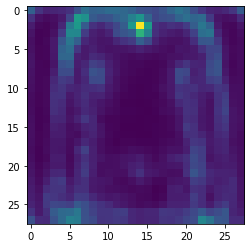

In [22]:
print(adv_expl.shape)
adv_expl = adv_expl.detach().cpu()
adv_expl_np = adv_expl.numpy()
adv_expl_np = adv_expl_np.reshape(224, 224)
im2 = Image.fromarray(adv_expl_np)
adv_expl2 = torchvision.transforms.ToTensor()(torchvision.transforms.Resize(side)(im2))
adv_expl_np2 = adv_expl2.numpy()
adv_expl_np2 = adv_expl_np2.reshape(side, side)
print(adv_expl_np2.shape)
plt.imshow(adv_expl_np2)

In [28]:
# role = 'adversary'
# dataset = 'fmnist'
# output_dir = '../data/'
# attack_method = 'cwl2/conf_0'
# exp_method = 'lrp'
# adv_src_class_idx = 5
# output_dir = output_dir + '/' + role + '/' + dataset + '/' + 'adv2/' + attack_method + '/' + exp_method + '/from_' + str(adv_src_class_idx) + '/'

# if not os.path.exists(output_dir):
#     print('creating directory ',output_dir)
#     os.makedirs(output_dir)

# print('storing results in ',output_dir)
# #np.save(output_dir+'x_adv2.npy', x_adv2_small_np)


creating directory  ../data//adversary/fmnist/adv2/cwl2/conf_0/lrp/from_5/
storing results in  ../data//adversary/fmnist/adv2/cwl2/conf_0/lrp/from_5/


# Now use the adv2 example and produce its explanation

In [42]:
print(type(x_adv2_small_np))
print(x_adv2_small_np.shape)
print(np.min(x_adv2_small_np), np.max(x_adv2_small_np))

<class 'numpy.ndarray'>
(28, 28)
0.0044801235 0.80561244


In [35]:
x2 = np_img_to_tensor(x_adv2_small_np, data_mean, data_std, device, num_ch=1)
print(type(x2))
print(torch.min(x2), torch.max(x2))
print(torch.mean(x2))

<class 'torch.Tensor'>
tensor(0.0039, device='cuda:0') tensor(0.7922, device='cuda:0')
tensor(0.0525, device='cuda:0')


In [52]:
x2.shape

torch.Size([1, 3, 224, 224])

torch.Size([1, 3, 224, 224])
original class of x [adv2 example] is  111
This is the explanation of the adv2 example


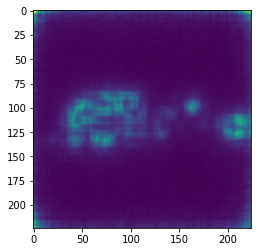

In [44]:

x_adv2 = x2.clone().detach().requires_grad_()
print(x2.shape)

x_pred = model(x2)
x_pred_class = torch.argmax(x_pred,axis=1)
print('original class of x [adv2 example] is ',int(x_pred_class))

org_expl2, _,_ = get_expl(model, x2, method)
org_expl2 = org_expl2.detach().cpu()

print('This is the explanation of the adv2 example')
org_expl_np2 = org_expl2.cpu().numpy()
plt.imshow(org_expl_np2[0])
